# NTDS assignment 2: network models
[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), *PhD student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

For this assignment we will work on a network representing the collaboration between scientists in the field of General Relativity and Quantum Cosmology. The network comes from [SNAP](http://snap.stanford.edu/data/ca-GrQc.html) and is described as follows:

> Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print [arXiv](https://arxiv.org) and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author *i* co-authored a paper with author *j*, the graph contains a undirected edge from *i* to *j*. If the paper is co-authored by *k* authors this generates a completely connected (sub)graph on *k* nodes. The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv.

In [931]:
%matplotlib inline

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
warnings.filterwarnings('ignore')
plt.style.use(['seaborn-whitegrid'])

In [882]:
G = nx.read_edgelist(os.path.join('..', 'data', 'arxiv_collaboration_network.txt'))

In [883]:
print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 5242 nodes.
My network has 14496 edges.


In [884]:
G.name='Collaboraton network'

## 1. Comparing to model networks

1.1 In this part of the assignment, you have to create an Erdős–Rényi and Barabási-Albert graph using NetworkX, and compare them to the collaboration network. Try to simulate the original network as best as you can. When choosing parameters for the networks, take into account the number of vertices and edges of the original network. The number of vertices should be exactly the same. Comment on your choice of parameters.

### Erdős–Rényi model:

There is two ways from which we can choose $p$:
1. From average degree $K$: $  p1=k/N$
2. From the number of links $L$ : $  p2= 2*L/((N-1)*N)$
> We will take p as the average of $p1$ and $p2$: $  p = (p1+p2)/2$

In [885]:
# Erdős–Rényi with n= N and estimated p

# K is the mean degree
k=np.mean(list(G.degree().values()))
num_nodes = len(G.nodes())
num_edges = G.size()

# Estimation from average degree
p1=k/num_nodes
# Estimation from number of links
p2= 2*num_edges/((num_nodes-1)*num_nodes)

print("Estimated Probability for edge creation from average degree p1= {}".format(str(p1)))
print("Estimated Probability for edge creation from average number of links p2= {}".format(str(p2)))

# Let's work with the avrage
p= (p1+p2)/2

print("p= avg (p1,p2)= {} ".format(str(p)))

Estimated Probability for edge creation from average degree p1= 0.00105507696836
Estimated Probability for edge creation from average number of links p2= 0.001055278280507905
p= avg (p1,p2)= 0.00105517762443 


In [886]:
er = nx.fast_gnp_random_graph(num_nodes,p)

In [887]:
er.name = 'Erdős–Rényi network'

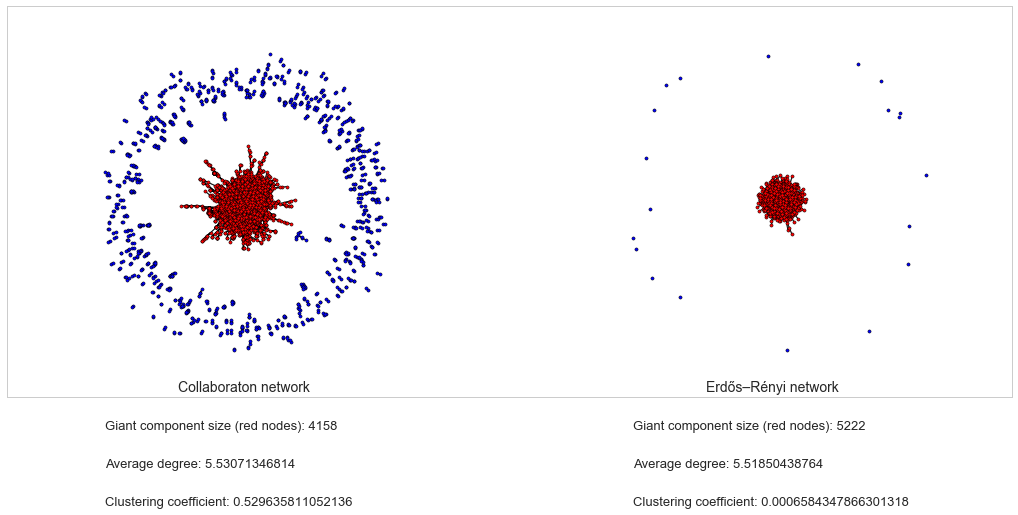

In [888]:
plot_comparaison (G,er,size_node=10,fig_size=[18,7],giant=True)

> Erdős–Rényi network is much more dense than the collaboration network. It doesn't capture the preferential attachment process.

### Barbasi-Albert model:

For the Barbasi-Albert model, we will build a graph with the same number of nodes as the original graph. However, $m$ need to be estimated.

The built in **barabasi_albert_graph(num_nodes,m)** Networkx function builds such a graph with the initial graph being with m nodes and no edges. I will make a slight change so that the initial graph is a Erdős–Rényi graph with $m0$ nodes with $p=1/(m0-1)$ so in expectation every node has one link and then add a link to every node with $0$ degree).

Now we need to choose m0 and m. Let's fix $m0$ (I chose $m0=615$ in a way to obtain m a natural number so that the number of edges of resulting graph is exactly the same as the original one).
Then we have that after every step $t$:
1. Number 0f nodes = $t + m0$
2. Number of edges = $m.t +m0$ [In expectation]

Hence, at the end, we have that $t= N-m0 => E= m.(N-m0) + m0 => m= (E-m0)/(N-m0)$

In [892]:
def barabasi_albert_graph(n, m,m0):
    import random as rd
    import secrets
    def _random_subset(list_,m):
        sampled=set()
        while len(sampled)<m:
            elem=secrets.choice(list_)
            sampled.add(elem)
        return sampled
    
    if (m0<m): 
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m<m0, m=%d,m0=%d"%(m,m0))
    # In expectation every node in the initial graph have 2 links
    p= 1.0/(m0-1)
    # Add m0 initial nodes in a Erdős–Rényi graph (all nodes are n average of degree 1)
    G=nx.fast_gnp_random_graph(m0,p)
    degrees = G.degree()
    # Make sure all nodes are of degree at least 1 
    for node in np.arange(m0):
        if degrees[node] ==0:
            rand_node=rd.randint(0,m0-1)
            while rand_node== node:
                rand_node=rd.randint(0,m0-1)
            G.add_edge(node,rand_node)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    # Target nodes for new edges
    targets=list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    # Start adding the other n-m nodes. The first node is m.
    source=m0
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source]*m,targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        source += 1
    return G

In [893]:
m0= 615
m= (int)((num_edges- m0)/(num_nodes- m0))
ba= barabasi_albert_graph(num_nodes,m,m0)
ba.name = 'Barabási-Albert network'

In [894]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

My Erdős–Rényi network has 5242 nodes.
My Erdős–Rényi network has 14464 edges.
My Barabási-Albert network has 5242 nodes.
My Barabási-Albert network has 14409 edges.


1.2 Check the size of the largest connected component in each graph and compare them to the original network. In the Erdős–Rényi model, what should the probability of creating each edge be in order to have the same expected size of the largest component? Justify. Generate a graph with this parameter to check if you indeed get a similar value.

In [895]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

4158
5222
4678


The size of the largest connected component of the Barabási-Albert network $(4646)$ is closer to the size of the largest connected component of the original graph $(4158)$ than the size of the Erdős–Rényi network $(5222)$. 
- Hence, we can approve the idea that in the GR-QC collaboration network networks, a new collaborator tend to link to the more connected contributors (with higher experience).
- Hence, follow a preferential attachment process
- Erdős–Rényi network assume a random choice of connections. Hence, doesn't capture the preferential attachment process.

We saw during the lecture that if S is the fraction of nodes in the GC, we have that $ S= 1 - exp( -E[k]*S ) $. Hence, we have that:
- $ exp ( -E[k]*S )= 1-S ==> E[k]*S= -ln (1-S) ==> E[k] = - ln(1-S)/S $

As we know that $E[k]= p.(N-1)$ we have that: $p= - ln(1-S)/(S*(N-1))$

So, if we want the Erdős–Rényi network to have in expectation the same size of the GC as the original network ($S=S_{or}$), we need to take:
- $p= - ln(1-S_{or})/(S_{or}*(N-1))$

In [897]:
import math
N=num_nodes
S_or = len(giant_G.nodes())/N
p_giant= -math.log(1-S_or)/(S_or*(N-1))
er = nx.gnp_random_graph(N,p_giant)
er_giant = max(nx.connected_component_subgraphs(er), key=len)
print('The parameter p for an Erdős–Rényi network with the same expected size of the giant component is {}.'.format(round(p_giant,10)))
print ('We need to divide p by a factor of {} to get in expectation the same GC size as the original network'.format(round(p/p_giant,3)))
print('The size of the component in a randomly generated network with this parameter is {}.'.format(len(er_giant.nodes())))

#Let's do some iterations to get close to the theoritical expectation
num_itarations =30
giant_size= []
for i in np.arange(num_itarations):
    er = nx.gnp_random_graph(N,p_giant)
    er_giant = max(nx.connected_component_subgraphs(er), key=len)
    giant_size.append(len(er_giant.nodes()))
mean_giant_size = (int)(round(np.mean(giant_size)))
error = (int)(abs(mean_giant_size-len(giant_G.nodes())))

print('The mean size of the component for {} iterations in a randomly generated network with this parameter is {}: only {} nodes far from the GC size of the original network.'.format(num_itarations,mean_giant_size,error))

The parameter p for an Erdős–Rényi network with the same expected size of the giant component is 0.0003791116.
We need to divide p by a factor of 2.783 to get in expectation the same GC size as the original network
The size of the component in a randomly generated network with this parameter is 4137.
The mean size of the component for 30 iterations in a randomly generated network with this parameter is 4154: only 4 nodes far from the GC size of the original network.


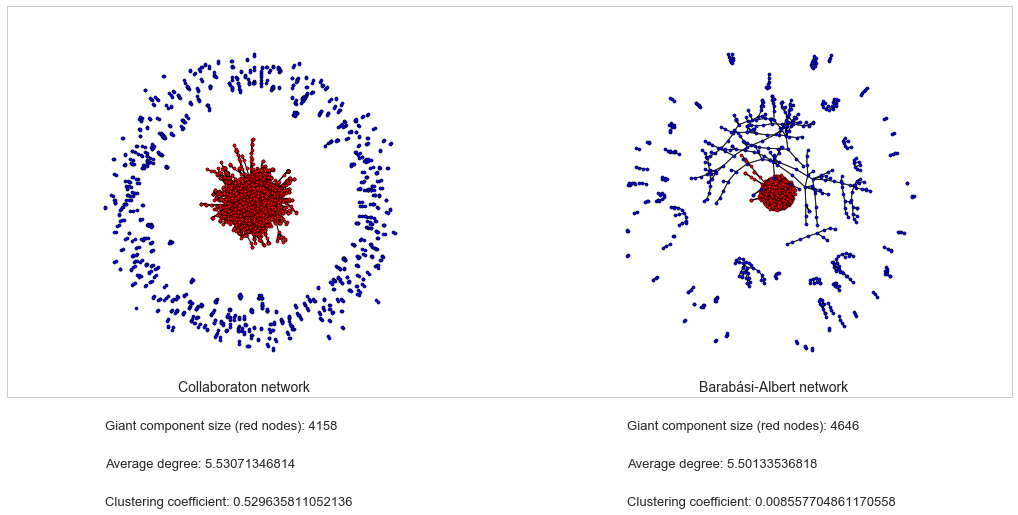

In [889]:
plot_comparaison (G,ba,size_node=10,fig_size=[18,7],giant=True)

1.3 Look at the clustering coefficient of the original network. Is there a network model we talked about that could have a clustering coefficient that is close? Explain.

In [359]:
nx.average_clustering(G)

0.529635811052136

This clustring coefficient is much higher than the coefficient of ER (0.0006) and BA (0.08) models. 

We saw in the lecture that Watts–Strogatz model fixes addresses the limitation of clustring of the Erdős–Rényi model for a reasonalble parameter  $\beta$: not too big (close to $1$) to not have again an ER model. 

To see that let's contruct a Watts–Strogatz graph with N nodes and the same average degree $K$ as the collaboation graph with $\beta = 0.1$ to have small word properties.

In [927]:
ws=nx.watts_strogatz_graph(N, math.ceil(k), 0.1, seed=None)
ws.name = 'Watts–Strogatz network'

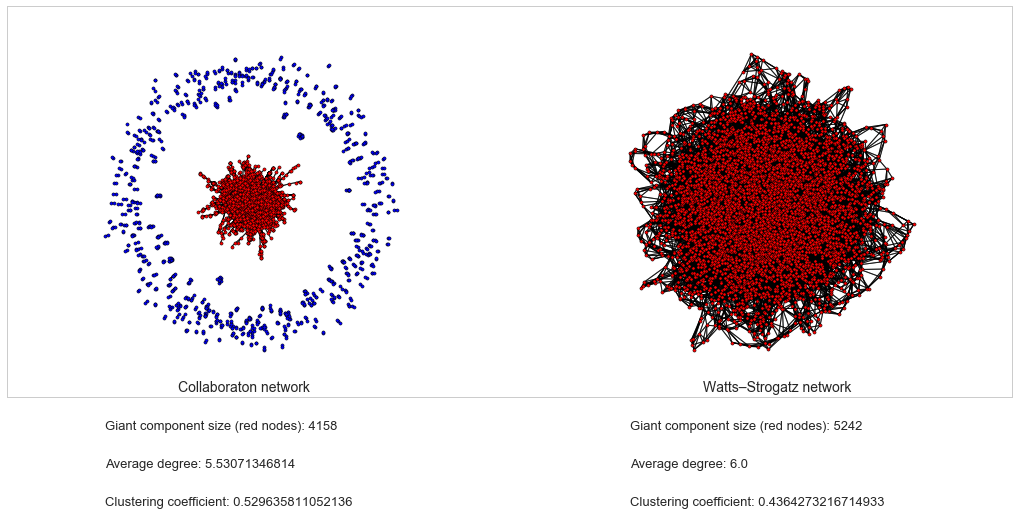

In [929]:
plot_comparaison (G,ws,size_node=10,fig_size=[18,7],giant=True)

> Clearly now we have a much better clustring coeficient of $0.436$

## 2. Creating a network with a predefined degree distribution

In this part of the assignment, you will have to create a random network from a predefined degree distribution. There are several network models which can create a random network with the exact same degree distribution as the original, or with the same expected distribution as the original. Refer to section 4.8 of [the Barabási book](http://networksciencebook.com) for more information.

One of the most famous ones is the configuration model. The model for a graph with $L$ edges in total is constructed in the following steps:

- Assign a degree to each node, represented as stubs (half-links). The degree sequence is either generated analytically from a preselected distribution, or it is extracted from the adjacency matrix of a real network. Note that we must start from an even number of stubs to avoid being left with unpaired stubs.
- Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining $2L - 2$ stubs and connect them. This procedure is repeated until all stubs are paired up.

*Reminder:* A stub is a half-link, representing the half of an edge. It contains one node and can be paired up with another stub to create an edge (between the two corresponding nodes).

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

The algorithm goes as follows:
- Extract the degree sequence from our collaboration network.
- Assign a target degree to each node, represented as stubs or half-links. Use the degree sequence extracted from the collaboration network.
- Sort the nodes by degree. 
    - Pick the node with the highest target degree. Delete all its stubs from the list of stubs to make sure we don't create a self loop.
    - Until all its weighted degree equals its target degree: 
        - Randomly select one stub from the list of stubs (corresponding to one of the other nodes), and connect these two nodes. In case the two chosen nodes are already connected, simply increase the weight of this edge by one. Be careful to randomly select from stubs and not from nodes, as this means the chances of selecting a node will be proportional to its target degree.
    - When the number of edges adjacent to this node corresponds to its target degree, go on to the second node in the list. 
    - Repeate this procedure until all stubs are paired up, or there is only one node left with a pair number of stubs. In that case, don't create a self-loop, but discard the stubs.
    
*Hints*: 
 - Use `nx.empty_graph()` to create an empty graph.
 - Use `G.add_edge(node1,node2,weight = 1)` to add an edge to a weighted graph.
 - Use `G.edge[node1][node2]['weight'] += 1` to increment the weight of an edge by one.

In [860]:
def greedy_configuration(degree_distribution):
    import random
    
    # assumes degree distribution is sorted and compy it a list that for every
    #node index i stores remaininig_stubs[i] the number of edges left to be connected with node i
    remaininig_stubs = list(degree_distribution)
    N= len(degree_distribution)
    
    # flattened stubs contains stubs list as discribed above
    flattened_stubs = []
    for i in np.arange(N):
        degree = degree_distribution[i]
        flattened_stubs= flattened_stubs+[i]*degree
    
    # remaining nodes keep track of the nodes that did not make all their connection yet
    remaining_nodes = list(np.arange(N))
    
    # create a graph
    graph = nx.empty_graph()
    graph.name = 'Greedy network'
    iteration =0
    
    # do until only one remaining node is left
    while len(remaining_nodes)>1:
        
        # take the node with the highest degree call it root
        root = remaining_nodes.pop(0)
        
        # delete all its stubs
        flattened_stubs=list(filter(lambda x: x != root, flattened_stubs))
        
        # read its remainig degree
        rem_degree = remaininig_stubs[root]
        
        # set it to zero
        remaininig_stubs[root]=0
        
        # do while the node still need connections
        while rem_degree>0:
            
            # decrease its remainig connections
            rem_degree = rem_degree-1
            
            # choose a stub randomly from remaining stubs
            rand =random.randint (0,len(flattened_stubs)-1)
            node=flattened_stubs.pop(rand)
            
            # decrease remaining connection for the chosen node
            remaininig_stubs[node] += -1
            
            # check whether the chosen node doesn't need more connections
            if remaininig_stubs[node] == 0: 
                remaining_nodes.remove(node)
                
            # connect root to the chosen node
            if graph.has_edge(root,node):
                graph.edge[root][node]['weight'] += 1
            else:
                graph.add_edge(root,node,weight = 1)
                
    return graph

In [861]:
degree_distribution=sorted(nx.degree(G,weight="weight").values(),reverse=True) # degree distribution sorted from highest to lowest
gc = greedy_configuration(degree_distribution)

2.2 Verify that the networks have the same number of nodes. Plot the difference between the weighted degree distributions to verify that they are identical. If not, why?

In [862]:
degree_sequence_gc=sorted(nx.degree(gc, weight = 'weight').values(),reverse=True) #weighted degree distribution
#check that the two distributions are identical. Error is the number of nodes where the
#original degree and the greedy degree differs.
error = len ([[d1,d2] for d1, d2 in zip(degree_distribution, degree_sequence_gc) if d1 != d2])
if (error > 1):
    print ("The distributions are not identical")
elif (error ==1):
    print ("The two distributions differ in only one vertex degree (which is tolerable by construction)")
else:
    print ("The distributions are identical")

The distributions are identical


By construction, we didn't allow self loops. Hence, at the end of the algorithm, it is possible to have the list of stubs containing stubs for a single node ! In such case we discard these stubs. Hence for every stub left we have an error of one edge in total (original total degree - greedy network degree). For example, if we are left with $4$ stubs of the same node we will have an error equal to $4$.

2.3 Should these two networks have the same adjacency matrices? Justify.

No these networks might not have the same adjacency matrix in fact the degree is the sum of all links for a node and doesn't mean that a node has the same connections with the exact set of nodes in the two graphs.

To see that we can construct a couter example as follows. We contruct a simple graph (cyclic with N=5), run greedy and compare the two adjacency matrices. All edges are of weight 1. 

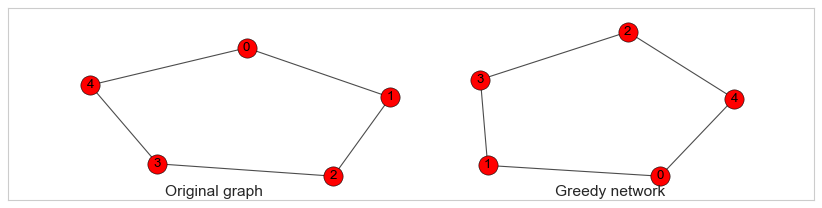

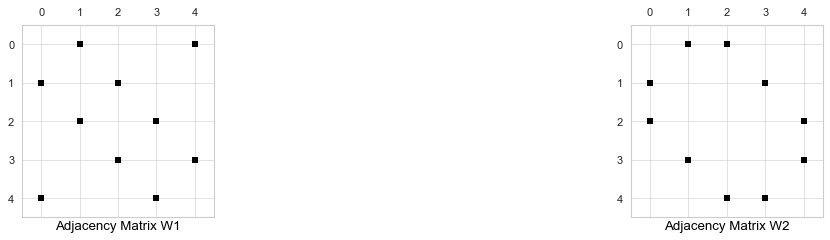

In [865]:
# G1 cyclic graph with 5 nodes
num_nodes=5
G1 = nx.cycle_graph(num_nodes)
G1.name ='Original graph'
# greedy
G2 = greedy_configuration(sorted(nx.degree(G1,weight="weight").values(),reverse=True))
# compare adjacency matrix of G1 and G2
plot_comparaison (G1,G2,adj_matrix=True,nodes_labels=True,fig_size=[13.0,3.0])

> Clearly the two adjacency matrices are not the same !

2.4 Draw both the generated and original networks. Are they similar? If not, why? Try to explain.

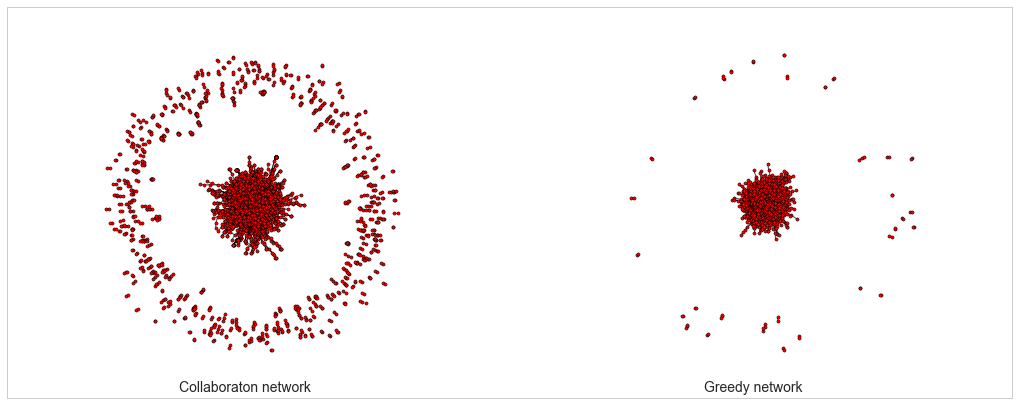

In [930]:
plot_comparaison (G,gc,size_node=10,fig_size=[18,7])

We can see that Greedy has a very big giant component (almost all nodes). Hence, greedy failed to capture the  preferential attachment process. In fact, by construction, the edge construction is random which makes it very likely that the resulting graph differs from the original one while maintaining the same degree distribution.

2.5 Do you expect the properties studied in the first part of the assignment to be close to the original graph? Justify.

Degree-preserving randomization would capture the characteristics of a network if these carecterisations emerged randomly. In such case, creating a large number of Degree-preserving graphs whould give a good approximation (e.g. confidence interval for example) of these caraterisations.

As the collaboration network is a real social scale-free network, I strongly bellieve that greedy network will fail spectacularly to model it and to give good bounds on its characteristics


Let's plot some of the caracteristics of the two graphs and explain why such differences.

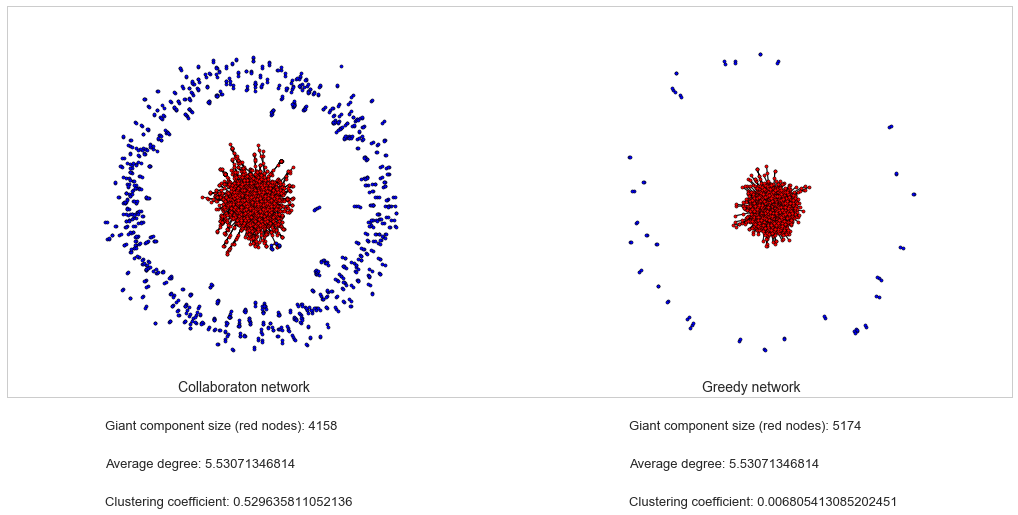

In [890]:
plot_comparaison (G,gc,size_node=10,fig_size=[18,7],giant=True)

The expectations are indeed verified because the greedy network has a very low clustering coefficient compared to the collaboration network and also the giant component is much bigger.
> we can reasonably posit that collaboration network is expressing characteristics that are non-random.

--------------------------------------------------------**NOT PART OF THE ASSIGNMENT**-------------------------------------------------------------

Helper Function to compare two graphs

In [879]:
def plot_comparaison (G1,G2,fig_size=[13,3],adj_matrix=False,nodes_labels=False,size_node=300,giant=False):
    
    def plot_weights(W1,W2):
        import matplotlib.pyplot as plt
        f,axarr = plt.subplots(1, 2)
        f.set_size_inches(18, fig_size[1])
        num_nodes =W1.shape[0]
        plt.figure(figsize=(num_nodes*2,num_nodes))
        range_ = list(np.arange(num_nodes))
        ticks = list(['node '+str(i) for i in range_])
        ax=axarr[0]
        ax.spy(W1,markersize=min(num_nodes,20))
        ax.set_xticks(range_, ticks)
        ax.set_yticks(range_, ticks)
        ax.set_title('Adjacency Matrix W1',fontsize= 12,color='k',y=-0.09)
        ax=axarr[1]
        ax.spy(W2,markersize=min(num_nodes,20))
        ax.set_xticks(range_, ticks)
        ax.set_yticks(range_, ticks)
        ax.set_title('Adjacency Matrix W2',fontsize= 12,color='k',y=-0.09)
        f.show()
        
    num_nodes = len(G1.nodes())
    W1 = nx.adjacency_matrix(G1)
    W2= nx.adjacency_matrix(G2)

    fig = plt.gcf()
    fig.set_size_inches(fig_size)

    x1 = 0.45*fig_size[0]
    x2 = 0.55*fig_size[0]
    y = 2 
    offx = 0.25
    offy = -0.64
    pos1=nx.spring_layout(G1,center=[x1,y])
    pos2=nx.spring_layout(G2,center=[x2,y])

    plt.text(x1-offx, y+offy, G1.name, fontsize=14)
    plt.text(x2-offx, y+offy, G2.name, fontsize=14)
    
    
    if (giant==True):
        # print caracteristics of G1
        components=list(nx.connected_component_subgraphs(G1))
        components.sort(key=len,reverse=True)
        nodes_giant = components[0].nodes()
        other_nodes = list(filter(lambda x: x not in nodes_giant, G1.nodes()))
        giant_G1 = len(nodes_giant)
        avg_degree = np.mean(list(nx.degree(G1, weight = 'weight').values()))
        cluster_coef = nx.average_clustering(G1)
        # Draw giant nodes in red and other nodes in blue
        nx.draw_networkx_nodes(G1, pos1, nodes_giant, node_size = size_node, node_color='r')
        nx.draw_networkx_nodes(G1, pos1, other_nodes, node_size = size_node, node_color='b')
        nx.draw_networkx_edges(G1,pos1, alpha=0.7)
        
        plt.text(x1-2*offx, y+1.2*offy, 'Giant component size (red nodes): {}'.format(giant_G1), fontsize=13)
        plt.text(x1-2*offx, y+1.4*offy, 'Average degree: {}'.format(str(avg_degree)), fontsize=13)
        plt.text(x1-2*offx, y+1.6*offy, 'Clustering coefficient: {}'.format(str(cluster_coef)), fontsize=13)
    
        # print caracteristics of G2
        components=list(nx.connected_component_subgraphs(G2))
        components.sort(key=len,reverse=True)
        nodes_giant = components[0].nodes()
        other_nodes = list(filter(lambda x: x not in nodes_giant, G2.nodes()))
        giant_G2 = len(nodes_giant)
        avg_degree = np.mean(list(nx.degree(G2, weight = 'weight').values()))
        cluster_coef = nx.average_clustering(G2)
        # Draw giant nodes in red and other nodes in blue
        nx.draw_networkx_nodes(G2, pos2, nodes_giant, node_size = size_node, node_color='r')
        nx.draw_networkx_nodes(G2, pos2, other_nodes, node_size = size_node, node_color='b')
        nx.draw_networkx_edges(G2,pos2, alpha=0.7)
        
        plt.text(x2-2*offx, y+1.2*offy, 'Giant component size (red nodes): {}'.format(giant_G2), fontsize=13)
        plt.text(x2-2*offx, y+1.4*offy, 'Average degree: {}'.format(str(avg_degree)), fontsize=13)
        plt.text(x2-2*offx, y+1.6*offy, 'Clustering coefficient: {}'.format(str(cluster_coef)), fontsize=13)
    
    else:
       
        nx.draw_networkx_nodes(G1, pos1, G1.nodes(), node_size = size_node)
        nx.draw_networkx_nodes(G2, pos2, G2.nodes(), node_size = size_node)
        
    nx.draw_networkx_edges(G2,pos2, alpha=0.7)
    nx.draw_networkx_edges(G1,pos1, alpha=0.7)
    
    if nodes_labels:
        nx.draw_networkx_labels(G1,pos1)
        nx.draw_networkx_labels(G2,pos2)
   
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    plt.margins(0.1)
    plt.show() 
    plt.draw()
    if adj_matrix:
        plot_weights(W1,W2)